In [1]:
import os
from pathlib import Path
from operator import itemgetter
import pickle
import pydicom
from time import time

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, LineString, GeometryCollection, Point, MultiPoint
from shapely.affinity import translate

from catch_converter.parse_contours import parse_cvi42ws
import CATCH_utils
from Mini_LL import *

# Convert Workspaces and Make Cases

In [ ]:
# after the dicoms receiving LL-tags 

# basepaths
bp       = '/Users/dietrichhadler/Desktop/Daten/CS_SAXCINE_Test/data'
bp_ws    = '/Users/dietrichhadler/Desktop/Daten/CS_SAXCINE_Test/data/JGold_workspaces'
bp_annos = '/Users/dietrichhadler/Desktop/Daten/CS_SAXCINE_Test/data/JGold'
bp_imgs  = '/Users/dietrichhadler/Desktop/Daten/CS_SAXCINE_Test/data/Imgs'

#bp       = '/Users/dietrichhadler/Desktop/Daten/test/data'
#bp_ws    = '/Users/dietrichhadler/Desktop/Daten/test/data/segm1_ws'
#bp_annos = '/Users/dietrichhadler/Desktop/Daten/test/data/segm1'
#bp_imgs  = '/Users/dietrichhadler/Desktop/Daten/test/data/Imgs'

# unpack the workspaces from ws_path to case_storage_path
cvi42ws_paths     = [f for f in os.listdir(bp_ws) if f.endswith('cvi42ws')]
for p in cvi42ws_paths: parse_cvi42ws(bp_ws, bp_annos, process=True, debug=True)

# get the paths of imgs and annotations via SeriesInstanceUIDs
imgsanno_paths = get_imgs_and_annotation_paths(bp_imgs, bp_annos)

cases = []
sax_cine_view = SAX_CINE_View()
sax_cs_view   = SAX_CS_View()
for imgp, annop in imgsanno_paths:
    st = time()
    case = Case(imgp, annop, os.path.basename(imgp), os.path.basename(bp_annos))
    case = sax_cine_view.customize_case(case)
    case = sax_cs_view.customize_case(case)
    case.store(bp)
    cases.append(case)
    print('Case customization took: ', time()-st, 'Case: ', case.reader_name, case.case_name)

# Load Cases and print Clinical Results

In [4]:
# load a case
bp = '/Users/dietrichhadler/Desktop/Daten/CS_SAXCINE_Test/data/JGold'
case_paths = [os.path.join(bp,p) for p in os.listdir(bp) if p.endswith('.pickle')]
cases = [pickle.load(open(p, 'rb')) for p in case_paths]

case  = cases[1]
print(case.case_name)

sax_cine_view = SAX_CINE_View()
sax_cs_view   = SAX_CS_View()

print('CS data:')
case = sax_cs_view.customize_case(case)
cat = [cat for cat in case.categories][0]
print('LV endo volume curve: ', cat.get_volume_curve('lv_endo'))
print([cat.phase for cat in case.categories])
for cr in case.crs: print(cr.name, cr.get_cr())
print([cr.get_cr(string=True) for cr in case.crs])

print('\nCINE data:')
case = sax_cine_view.customize_case(case)
cat = [cat for cat in case.categories][0]
print('LV endo volume curve: ', cat.get_volume_curve('lv_endo'))
print([(cat.name, cat.phase) for cat in case.categories])
st = time()
for cr in case.crs: print(cr.name, cr.get_cr())
print([cr.get_cr(string=True) for cr in case.crs])

ECSPRESS-128
CS data:
LV endo volume curve:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 47.506286238670114, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128.47283999883967]
[9, 24, 9, 24]
LVESV 47.506286238670114
LVEDV 128.47283999883967
RVESV 100.03531426590718
RVEDV 174.76772361594146
LVSV 80.96655376016956
LVEF 0.6302231176742928
RVSV 74.73240935003429
RVEF 0.42760990304384755
LVMYOMASS 108.49944854491778
RVMYOMASS 108.49944854491778
LVESP 9
RVESP 9
LVEDP 24
RVEDP 24
LVEDP 16
['47.51', '128.47', '100.04', '174.77', '80.97', '0.63', '74.73', '0.43', '108.50', '108.50', '9', '9', '24', '24', '16']

CINE data:
LV endo volume curve:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51.508770379052514, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 130.42781899501736, 0, 0, 0, 0, 0]
[('SAX LVES', 11), ('SAX LVED', 24), ('SAX RVES', 11), ('SAX RVED', 24)]
LVESV 51.508770379052514
LVEDV 130.42781899501736
RVESV 107.17333960924213
RVEDV 186.15836688737966
LVSV 78.91904861596484
LVEF 0.6050783431360962
RVSV 78.98502727813752
RVEF 0.42

# Checking Contours on Imgs

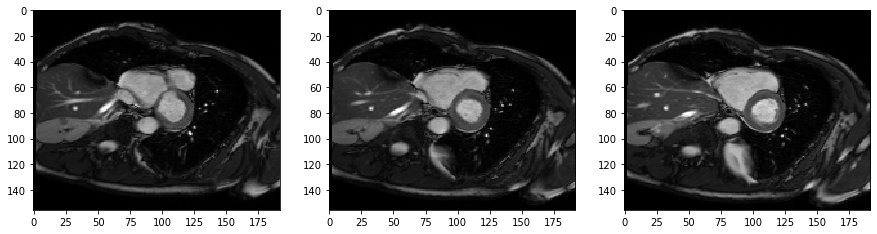

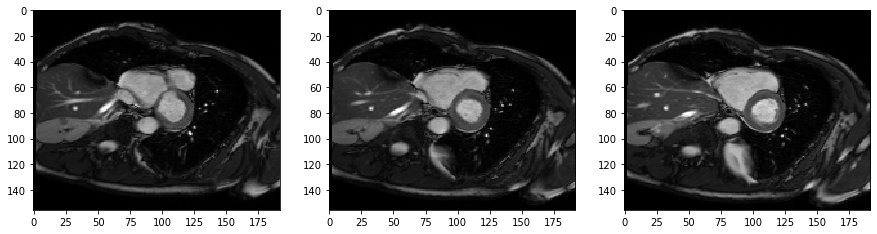

In [5]:
cat = case.categories[0]
fig, ax = plt.subplots(1,3,figsize=(15,15))
for i in range(3):
    img  = cat.get_img (2+i, 29)
    anno = cat.get_anno(2+i, 29)
    ax[i].imshow(img, interpolation='none', cmap='gray')
    if anno is not None: anno.plot_all_contour_outlines(ax[i])
plt.show()

fig, ax = plt.subplots(1,3,figsize=(15,15))
for i in range(3):
    img  = cat.get_img (2+i, 29)
    anno = cat.get_anno(2+i, 29)
    ax[i].imshow(img, interpolation='none', cmap='gray')
    anno.plot_contour_face(ax[i], 'lv_myo', c='r', alpha=0.4)
    anno.plot_all_contour_outlines(ax[i])
plt.show()

# Load Trainee Cases for Comparisons

In [6]:
case1 = pickle.load(open('/Users/dietrichhadler/Desktop/Daten/test/data/segm1/segm1_178-lvma_LL_case.pickle', 'rb'))
case2 = pickle.load(open('/Users/dietrichhadler/Desktop/Daten/test/data/segm2/segm2_178-lvma_LL_case.pickle', 'rb'))
case_comp = Case_Comparison(case1, case2)
print(case_comp)

In [9]:
case1 = sax_cine_view.customize_case(case1)
case2 = sax_cine_view.customize_case(case2)
cr_pairs = zip(case1.crs, case2.crs)
for cr1, cr2 in cr_pairs:
    print(cr1.name, cr2.name, cr1.get_cr(), cr2.get_cr(), cr1.get_cr_diff(cr2))


LVESV LVESV 103.49857177734376 103.24478759765626 0.2537841796875
LVEDV LVEDV 184.06505126953124 179.65843505859374 4.4066162109375
RVESV RVESV 0.0 0.0 0.0
RVEDV RVEDV 0.0 0.0 0.0
LVSV LVSV 80.56647949218748 76.41364746093748 4.15283203125
LVEF LVEF 0.4377065550307765 0.42532735764168617 0.012379197389090324
RVSV RVSV 0.0 0.0 0.0
RVEF RVEF 1.0 1.0 0.0
LVMYOMASS LVMYOMASS 118.54371505737305 121.87766052246094 -3.3339454650878935
RVMYOMASS RVMYOMASS 0.0 0.0 0.0
LVESP LVESP 10 9 1
RVESP RVESP nan nan nan
LVEDP LVEDP 29 29 0
RVEDP RVEDP nan nan nan
LVEDP LVEDP 17 17 0


## Fast metric calculations

In [ ]:
metric = HausdorffMetric()
metric.set_case_comparison(case_comp)
hausdorff_dict = metric.calculate_all_vals(True)

metric = DiceMetric()
metric.set_case_comparison(case_comp)
dice_dict = metric.calculate_all_vals(True)

metric = mlDiffMetric()
metric.set_case_comparison(case_comp)
mldiff_dict = metric.calculate_all_vals(True)

## Get Contour Comparison Visualizations for large ml Diffs

In [ ]:
for sop, c in mldiff_dict.keys():
    if np.abs(mldiff_dict[(sop,c)]) > 2:
        print(c, 'mldiff: ', mldiff_dict[(sop,c)])
        img   = case1.get_img(sop)
        anno1 = case1.load_anno(sop)
        anno2 = case2.load_anno(sop)
        if not anno1.has_contour(c) or not anno2.has_contour(c): continue
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        ax.imshow(img, interpolation='none', cmap='gray')
        anno1.plot_cont_comparison(ax, anno2, c)
        plt.show()

In [ ]:
cat = case1.categories[0]; print(cat.phase)
fig, ax = plt.subplots(1,4,figsize=(20,20))
for i in range(4):
    img, anno = cat.get_img (1+i, cat.phase), cat.get_anno(1+i, cat.phase)
    ax[i].imshow(img, cmap='gray')
    anno.plot_contour_face(ax[i], 'lv_endo', c='r', alpha=0.4); anno.plot_all_contour_outlines(ax[i])
plt.show()
cat = case2.categories[0]; print(cat.phase)
fig, ax = plt.subplots(1,4,figsize=(20,20))
for i in range(4):
    img, anno = cat.get_img (1+i, cat.phase), cat.get_anno(1+i, cat.phase)
    ax[i].imshow(img, cmap='gray')
    anno.plot_contour_face(ax[i], 'lv_endo', c='r', alpha=0.4); anno.plot_all_contour_outlines(ax[i])
plt.show()

## Testing to_mask and to_poly function

In [ ]:
cat = case1.categories[0]
print(cat.phase)
fig, ax = plt.subplots(1,4,figsize=(20,20))
for i in range(4):
    img, anno = cat.get_img (1+i, 10), cat.get_anno(1+i, 10)
    mask = CATCH_utils.to_mask(anno.get_contour('lv_endo'), 200, 200)
    poly = CATCH_utils.to_polygon(mask)
    ax[i].imshow(img, cmap='gray')
    if not poly.is_empty: CATCH_utils.plot_outlines(ax[i], poly)
plt.show()

## Get a Datafram of comparisons

In [ ]:
analyzer = SAX_CINE_analyzer(case_comp)
# Reduce to first reader with argument! Get 'cross phase' with False (typically for reader comparison)
#metric = DiceMetric()
#analyzer.get_metric_values_depth_time(metric, cont_name='lv_myo', fixed_phase_first_reader=False)
table = analyzer.get_case_contour_comparison_pandas_dataframe(fixed_phase_first_reader=True, debug=True)
print(len(table))
table.iloc[40:100,:]